In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import monad
import scipy.stats
import nve_basic
import gsd.hoomd
import ghalton
import itertools
import scipy.spatial
reload(monad)


Input parameters
Number of particles 256
Initial temperature 1.00000000e+00
Box size 5.30000000e+00
epsilon 1.00000000e+00
sigma 1.00000000e+00
dt 5.00000000e-03
Total time 1.00000000e+02
Number of steps 20000


<module 'monad' from 'monad.pyc'>

Numpy vectorization approach adapted from https://www.labri.fr/perso/nrougier/from-python-to-numpy/#boids

### Begin with a 2D LJ simulation

This will be a 2-dimensional simulation of Lennard-Jones particles using all dimensionless parameters:
* Time step $t = 1$
* Particle mass $m = 1$
* Temperature $T = 1$
* LJ potential width $\sigma=1$
* LJ potential depth $\epsilon=1$

In [3]:
# Define simulation settings
n = 32
L = 10.  # Simulation box size
sigma = 1.
epsilon = 1.
rcut = 20.
nlog = 10 # Log to trajectory every dtlog time steps
dt = .5

In [4]:
pos, L = nve_basic.fcc_positions(n, .1)
# gh = ghalton.Halton(3)
# pos = np.array(gh.get(256))

(-3.4199518933533937, 3.4199518933533937)

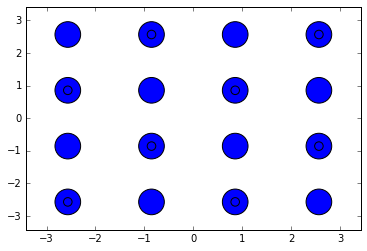

In [6]:
# Visualize uniform initial positions in simulation box
plt.scatter(pos[:,0], pos[:,1], s=pos[:,2]**2 * 100)
plt.xlim(-L/2., L/2)
plt.ylim(-L/2., L/2)

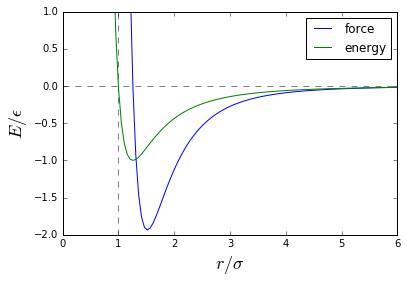

In [30]:
x = np.linspace(.9, 6, 100)
force = monad.lj(x, 1, 1)[0]
energy = monad.lj(x, 1, 1)[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, force, label='force')
ax.plot(x, energy, label='energy')
ax.hlines(0, 0, 6, color = 'gray', linestyle='--')
ax.vlines(1, -2, 1, color = 'gray', linestyle='--')
# ax.set_title('Lennard Jones Potential')
ax.set_ylim(-2,1)
ax.legend()
ax.set_xlabel(r'$r/\sigma$', fontsize=18)
ax.set_ylabel(r'$E/\epsilon$', fontsize=18)
fig.savefig('f/lj_force.png', dpi=400, bbox_inches='tight')

In [478]:
reload(monad)

<module 'monad' from 'monad.py'>

In [479]:
len(pos) / L**3

0.15000000000000008

In [480]:
lj_force.shape

(65280,)

In [511]:
import multiprocessing

In [566]:
%%time
# Initialize and run trajectory
np.random.seed(1)
n = 256
rho = 1.2
T0 = 1.8
nframes = 1000
nframes_eq = 50
dt = .005
nlog=10
ptraj, vtraj, etraj, temptraj, prestraj = monad.run(n = n , rho = rho, T0 = T0, nframes = nframes, 
                                                    nframes_eq = nframes_eq, dt=dt, nlog=nlog)

CPU times: user 49.9 s, sys: 320 ms, total: 50.2 s
Wall time: 26.5 s


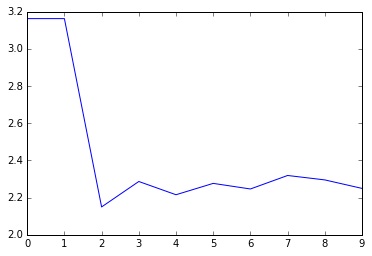

In [561]:
plt.plot(temptraj)

In [516]:
rhos = np.arange(.2,1.3,.1)
prestrajs = []
for rho in rhos:
    ptraj, vtraj, etraj, temptraj, prestraj = monad.run(n = n , rho = rho, T0 = T0, nframes = nframes, 
                                                        nframes_eq = nframes_eq, dt=dt, nlog=nlog)
    prestrajs.append(prestraj)

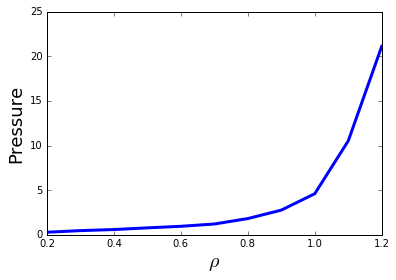

In [551]:
ps = [np.mean(traj[10:]) for traj in prestrajs]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rhos, ps, lw=3)
ax.set_xlim(0.2,1.2)
ax.set_xlabel(r'$\rho$', fontsize=20)
ax.set_ylabel('Pressure', fontsize=18)
fig.savefig('f/rho_p.png', dpi=400, bbox_inches='tight')

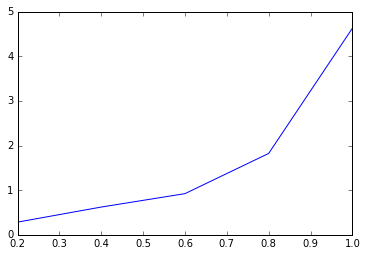

In [499]:
plt.plot(rhos, ps)

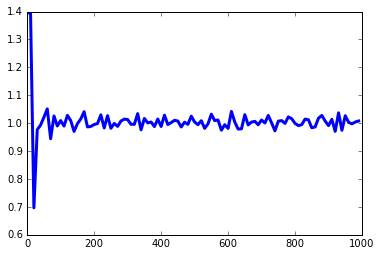

In [574]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(len(temptraj))*nlog
ax.plot(x, temptraj*1.04, lw=3.)
# ax.text(400, 16, r'$\rho = 1.2, T_0 = 1.8$', fontsize=20)
fig.savefig('f/pressure_traj.png', dpi=600, bbox_inches='tight')

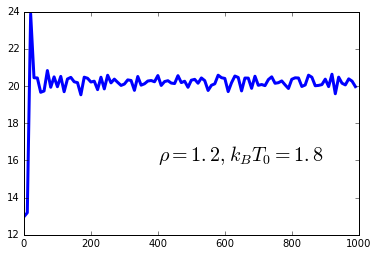

In [575]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(len(prestraj))*nlog
ax.plot(x, prestraj, lw=3.)
ax.text(400, 16, r'$\rho = 1.2, k_B T_0 = 1.8$', fontsize=20)
fig.savefig('f/pressure_traj.png', dpi=600, bbox_inches='tight')

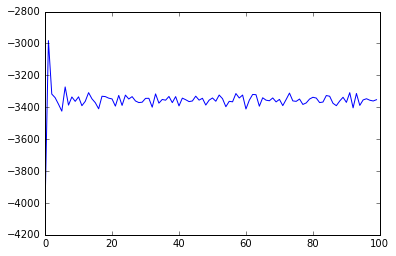

In [576]:
plt.plot(etraj)

In [231]:
mindist = 1000
pos = ptraj[-1]
for i in range(len(pos)):
    for j in range(len(pos)):
        if i == j: continue
        r = np.linalg.norm(pos[i] - pos[j])
        if r < mindist:
            mindist = r

In [384]:
pos = ptraj[0][:5]
vel = vtraj[0][:5]
# Determine particles within cutoff radius
dx = np.subtract.outer(pos[:, 0], pos[:, 0])
dy = np.subtract.outer(pos[:, 1], pos[:, 1])
dz = np.subtract.outer(pos[:, 2], pos[:, 2])

# # Apply "minimum image" convention: interact with nearest periodic image
dx = monad.apply_pbc(dx, L)  # x component of i-j vector
dy = monad.apply_pbc(dy, L)  # y component of i-j vector
dz = monad.apply_pbc(dz, L)  # y component of i-j vector
r2 = dx**2 + dy**2 + dz**2  # Squared distance between all particle pairs
mask = r2 > 0
np.min(r2[mask])

4.2260935172056406

In [413]:
px = np.dot(fx.ravel(), np.abs(dx.ravel()))
py = np.dot(fy.ravel(), np.abs(dy.ravel()))
pz = np.dot(fz.ravel(), np.abs(dz.ravel()))
.5 * (px + py + pz)

2.6467716907063732e-13

In [425]:
np.dot(-lj_force, r2[mask].ravel())

303.38454904059597

In [421]:
np.dot(np.sqrt(fx**2 + fy**2 + fz**2).ravel(), np.sqrt(r2.ravel()))

3905.6327349023359

In [411]:
dx.ravel()[1]

-3.460625163409297

In [410]:
fx.ravel()[1]

-7.6565472525935124e-05

In [406]:
px = np.dot(lj_force, np.square(dx[mask].ravel()))
py = np.dot(lj_force, np.square(dy[mask].ravel()))
pz = np.dot(lj_force, np.square(dz[mask].ravel()))
.5 * (px + py + pz)

-151.6922745202977

In [402]:
fx.ravel()

array([  0.00000000e+00,  -7.65654725e-05,  -7.99932182e-06, ...,   8.25929259e-05,
         7.26279314e-02,   0.00000000e+00])

In [396]:
np.dot(lj_force, np.sqrt(r2[mask]))

512.5065737119935

In [397]:
dx

array([[ 0.        , -3.46062516, -4.77958064, ...,  3.89280159,  3.00364975,  2.15199973],
       [ 3.46062516,  0.        , -1.31895547, ..., -4.59698591, -5.48613774,  5.61262489],
       [ 4.77958064,  1.31895547,  0.        , ..., -3.27803043, -4.16718227, -5.0188323 ],
       ..., 
       [-3.89280159,  4.59698591,  3.27803043, ...,  0.        , -0.88915183, -1.74080186],
       [-3.00364975,  5.48613774,  4.16718227, ...,  0.88915183,  0.        , -0.85165003],
       [-2.15199973, -5.61262489,  5.0188323 , ...,  1.74080186,  0.85165003,  0.        ]])

In [467]:
lj_force

array([ 4.87537678,  5.56242383,  1.4431762 , ...,  4.01097754,  9.15355409,  0.53495719])

In [471]:
lj_force

array([ 4.87537678,  5.56242383,  1.4431762 , ...,  4.01097754,  9.15355409,  0.53495719])

In [477]:
np.dot(np.abs(lj_force), r2[mask].ravel()) / (6. * L**3)

1.714547468386928

In [462]:
L = (256 / .15)**(1. / 3.)
pos = ptraj[-1]
vel = vtraj[-1]
# Determine particles within cutoff radius
dx = np.subtract.outer(pos[:, 0], pos[:, 0])
dy = np.subtract.outer(pos[:, 1], pos[:, 1])
dz = np.subtract.outer(pos[:, 2], pos[:, 2])

# Apply "minimum image" convention: interact with nearest periodic image
dx = monad.apply_pbc(dx, L)  # x component of i-j vector
dy = monad.apply_pbc(dy, L)  # y component of i-j vector
dz = monad.apply_pbc(dz, L)  # y component of i-j vector

r2 = dx**2 + dy**2 + dz**2  # Squared distance between all particle pairs

# Select interaction pairs within cutoff distance
# (also ignore self-interactions)
mask = r2 < rcut**2
mask *= r2 > 0

# Compute forces
lj_force, lj_energy = monad.lj(r2[mask], sigma, epsilon)
fx = np.zeros_like(dx)
fx[mask] = -dx[mask] * lj_force  # Negative sign so dx points from j to i
fy = np.zeros_like(dy)
fy[mask] = -dy[mask] * lj_force  # Negative sign so dy points from j to i
fz = np.zeros_like(dz)
fz[mask] = -dz[mask] * lj_force  # Negative sign so dz points from j to i
net_fx = np.sum(fx, axis=0)
net_fy = np.sum(fy, axis=0)
net_fz = np.sum(fz, axis=0)
forces = np.stack([net_fx, net_fy, net_fz], axis=1)
energy = np.sum(lj_energy)

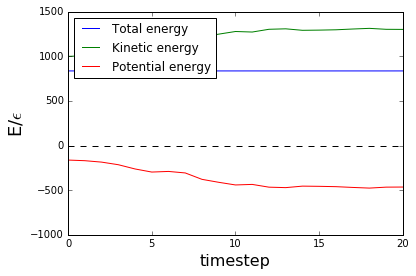

In [222]:
kinetic_energy = np.sum(vtraj**2, axis=(1,2))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(kinetic_energy + etraj, label='Total energy')
ax.plot(kinetic_energy, label='Kinetic energy')
ax.plot(etraj, label='Potential energy')
ax.set_ylabel(r'E/$\epsilon$', fontsize=18)
ax.set_xlabel('timestep', fontsize=16)
ax.set_xlim(0,20)
# ax.set_ylim(-1000,1000)
# ax.set_yscale('log')
ax.hlines(0, 0, 300, linestyle='--')
ax.legend(loc='upper left')
# fig.savefig('energy_conserved.png', dpi=400, bbox_inches='tight')
# fig.savefig('energy_not_conserved.png', dpi=400, bbox_inches='tight')

# ax2 = fig.add_subplot(122)
# ax2.plot(kinetic_energy + etraj, label='Total energy')
# ax2.set_xlabel('timestep')
# avg = np.mean(kinetic_energy + etraj)
# ax2.set_ylim(avg - 10, avg + 10)
# # ax2.legend(loc='best')

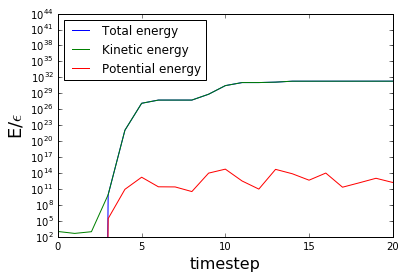

In [82]:
kinetic_energy = np.sum(vtraj**2, axis=(1,2))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(kinetic_energy + etraj, label='Total energy')
ax.plot(kinetic_energy, label='Kinetic energy')
ax.plot(etraj, label='Potential energy')
ax.set_ylabel(r'E/$\epsilon$', fontsize=18)
ax.set_xlabel('timestep', fontsize=16)
ax.set_xlim(0,20)
# ax.set_ylim(-1000,1000)
ax.set_yscale('log')
ax.hlines(0, 0, 300, linestyle='--')
ax.legend(loc='upper left')
# fig.savefig('energy_conserved.png', dpi=400, bbox_inches='tight')
fig.savefig('energy_not_conserved.png', dpi=400, bbox_inches='tight')

# ax2 = fig.add_subplot(122)
# ax2.plot(kinetic_energy + etraj, label='Total energy')
# ax2.set_xlabel('timestep')
# avg = np.mean(kinetic_energy + etraj)
# ax2.set_ylim(avg - 10, avg + 10)
# # ax2.legend(loc='best')

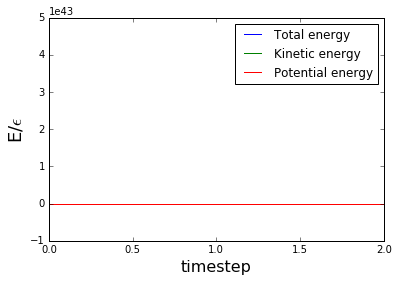

In [70]:
kinetic_energy = np.sum(vtraj**2, axis=(1,2))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(kinetic_energy + etraj, label='Total energy')
ax.plot(kinetic_energy, label='Kinetic energy')
ax.plot(etraj, label='Potential energy')
ax.set_ylabel(r'E/$\epsilon$', fontsize=18)
ax.set_xlabel('timestep', fontsize=16)
ax.set_xlim(0,2)
ax.hlines(0, 0, 300, linestyle='--')
ax.legend(loc='best')
# fig.savefig('energy_conserved.png', dpi=400, bbox_inches='tight')
fig.savefig('energy_not_conserved.png', dpi=400, bbox_inches='tight')

# ax2 = fig.add_subplot(122)
# ax2.plot(kinetic_energy + etraj, label='Total energy')
# ax2.set_xlabel('timestep')
# avg = np.mean(kinetic_energy + etraj)
# ax2.set_ylim(avg - 10, avg + 10)
# # ax2.legend(loc='best')

## Visualize the trajectory

In [260]:
def create_frame(frame, i):
    s = gsd.hoomd.Snapshot()
    s.configuration.step = i
    s.particles.N = len(frame)
    s.particles.position = frame
    s.particles.diameter = np.ones(len(frame)) * .1
    return s

In [261]:
def write_gsd(f, ptraj, vtraj, sigma, L):
    fd = gsd.hoomd.open(name=f, mode='wb')
    for i in range(len(ptraj)):
        frame = ptraj[i]
        vframe = vtraj[i]
        fd.append(create_frame(frame, i))

In [262]:
write_gsd('test.gsd', ptraj, vtraj, sigma, L)

__Now open in ovito to visualize__

In [263]:
fd = open('test.txt', 'w')
fd.write()

TypeError: function takes exactly 1 argument (0 given)

In [91]:
def write_xyz(f, ptraj):
    with open(f, 'wb') as fd:
        fd.write(str(len(ptraj)) + '\n')
        fd.write('\n')
        for vec in ptraj:
            fd.write('Ar {}\n'.format('  '.join([str(x) for x in vec])))

In [92]:
write_xyz('test.xyz', ptraj)

In [ ]:
nve_basic.create_frame(ptraj, vtraj, sigma, L, frame):

In [76]:
%%bash 
rm f/lj/*.png

In [77]:
def write_frames(ptraj, start=0, stop=None, stride=1, dpi=100):
    if stop is None:
        stop = len(ptraj)
    for count, frameid in enumerate(range(start, stop, stride)):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(*ptraj[frameid].T)
        ax.set_xlim(-L/2, L/2)
        ax.set_ylim(-L/2, L/2)
        fig.savefig('f/lj/{}.png'.format(count), dpi=100, bbox_inches='tight')
        plt.close(fig)    

In [78]:
write_frames(ptraj, 0, None, 5, dpi=50)

/home/chargus/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:806: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [134]:
%%bash
ffmpeg -framerate 15 -i f/lj/%d.png f/lj/out.mp4 -y  -loglevel error

<video controls src="f/lj/out.mp4" />

## Convergence testing on $\Delta t$

In [2]:
nve_basic.fcc_positions(200, 10)

array([[ 0.05,  0.05,  0.05],
       [ 0.05,  0.15,  0.15],
       [ 0.15,  0.15,  0.05],
       [ 0.15,  0.05,  0.15],
       [ 0.05,  0.05,  0.25],
       [ 0.05,  0.15,  0.35],
       [ 0.15,  0.15,  0.25],
       [ 0.15,  0.05,  0.35],
       [ 0.05,  0.05,  0.45],
       [ 0.05,  0.15,  0.55],
       [ 0.15,  0.15,  0.45],
       [ 0.15,  0.05,  0.55],
       [ 0.05,  0.05,  0.65],
       [ 0.05,  0.15,  0.75],
       [ 0.15,  0.15,  0.65],
       [ 0.15,  0.05,  0.75],
       [ 0.05,  0.25,  0.05],
       [ 0.05,  0.35,  0.15],
       [ 0.15,  0.35,  0.05],
       [ 0.15,  0.25,  0.15],
       [ 0.05,  0.25,  0.25],
       [ 0.05,  0.35,  0.35],
       [ 0.15,  0.35,  0.25],
       [ 0.15,  0.25,  0.35],
       [ 0.05,  0.25,  0.45],
       [ 0.05,  0.35,  0.55],
       [ 0.15,  0.35,  0.45],
       [ 0.15,  0.25,  0.55],
       [ 0.05,  0.25,  0.65],
       [ 0.05,  0.35,  0.75],
       [ 0.15,  0.35,  0.65],
       [ 0.15,  0.25,  0.75],
       [ 0.05,  0.45,  0.05],
       [ 0

## Calculate g(r)

In [755]:
%%time
# Initialize and run trajectory
np.random.seed(1)
n = 256
rho = .7
L = (n / rho)**(1. / 3.)
T0 = 1.8
nframes = 4000
nframes_eq = 50
dt = .005
nlog = 10
ptraj, vtraj, etraj, temptraj, prestraj = monad.run(n = n , rho = rho, T0 = T0, nframes = nframes, 
                                                    nframes_eq = nframes_eq, dt=dt, nlog=nlog)

CPU times: user 3min 40s, sys: 1.34 s, total: 3min 42s
Wall time: 1min 57s


In [756]:
def pbc_pdist(pos, L):
    """Compute all pairwise distances with PBCs
    """
    dx = np.subtract.outer(pos[:, 0], pos[:, 0])
    dy = np.subtract.outer(pos[:, 1], pos[:, 1])
    dz = np.subtract.outer(pos[:, 2], pos[:, 2])

    # Apply "minimum image" convention: interact with nearest periodic image
    dx = monad.apply_pbc(dx, L)  # x component of i-j vector
    dy = monad.apply_pbc(dy, L)  # y component of i-j vector
    dz = monad.apply_pbc(dz, L)  # y component of i-j vector

    r2 = dx**2 + dy**2 + dz**2  # Squared distance between all particle pairs
    r2 = r2[np.triu_indices(len(dx), k = 1)]  # Extract only unique entries (could have done this sooner)
    return np.sqrt(r2)


In [757]:
dists = []
for frame in ptraj:
    dists += list(pbc_pdist(frame, L))

In [758]:
y, x = np.histogram(dists, 100, (0, L/2.))


In [775]:
y, x = np.histogram(dists, 100, (0, L/2.))
y = y.astype(float)
x = np.array(x[:-1] + (x[1] - x[0]))
y /= x**2
# y /= (4*np.pi*rho/3.) 
# y /= (n * (nframes / nlog))


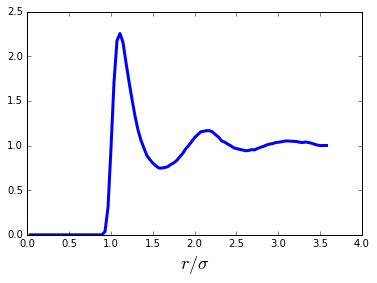

In [776]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,y/y[-1], lw=3)
ax.set_xlabel(r'$r/\sigma$', fontsize=18)
fig.savefig('f/gofr_liq.png', dpi=600, bbox_inches='tight')

## Compute diffusion coefficient from autocorrelation functions

In [ ]:
%%time
# Initialize and run trajectory
np.random.seed(1)
n = 256
rho = .7
L = (n / rho)**(1. / 3.)
T0 = 4.0
nframes = 4000
nframes_eq = 50
dt = .005
nlog = 10
ptraj, vtraj, etraj, temptraj, prestraj = monad.run(n = n , rho = rho, T0 = T0, nframes = nframes, 
                                                    nframes_eq = nframes_eq, dt=dt, nlog=nlog)

In [985]:
# Velocity autocorrelation
autocorrs = []
tshifts = range(0,200)
for tshift in tshifts:
    if tshift == 0:
        autocorr = 1.
    else:
        a = vtraj[tshift:] 
        b = vtraj[:-tshift]
        autocorr = np.sum(np.sum(a * b, axis=-1)) / (3 * np.multiply(*a.shape[:-1]))
    autocorrs.append(autocorr)

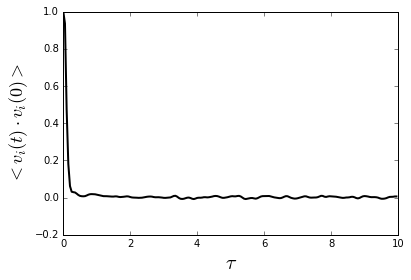

In [986]:
fig = plt.figure()
ax = fig.add_subplot(111)
t = np.array(tshifts) * nlog * dt
ax.plot(t, autocorrs, lw=2, c='k')
ax.set_xlabel(r'$\tau$', fontsize=20)
ax.set_ylabel(r'$<v_i(t) \cdot v_i(0)>$', fontsize=18)
fig.savefig('f/velocity_autocorrelation.png', dpi=600, bbox_inches='tight')

In [981]:
np.trapz(autocorrs[:40], t[:40])

4.6610722648011471

In [982]:
# Displacement autocorrelation
autocorrs = []
tshifts = range(1,200)
for tshift in tshifts:
    a = ptraj[tshift:] 
    b = ptraj[:-tshift]
    autocorr = np.sum(np.sum((a - b)**2, axis=-1)) / (3 * np.multiply(*a.shape[:-1]))
    autocorrs.append(autocorr)

In [983]:
t = np.array(tshifts) * nlog * dt
start = 140
end = 200
fit = scipy.stats.linregress(t[start:end], autocorrs[start:end])
print fit
D = fit.slope * nlog
print D

LinregressResult(slope=0.26576941798482723, intercept=4.2266225533529465, rvalue=0.99216287764057576, pvalue=3.4643374911557538e-53, stderr=0.0044332818118911713)
2.65769417985


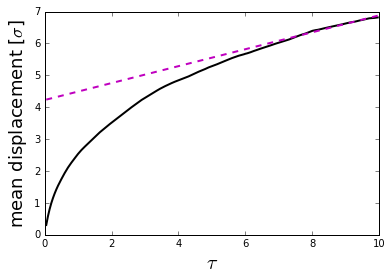

In [984]:
fig = plt.figure()
ax = fig.add_subplot(111)
t = np.array(tshifts) * nlog * dt
yfit = fit.intercept + fit.slope*t
ax.plot(t, autocorrs, lw=2, c='k')
ax.plot(t, yfit, lw=2, c='m', linestyle='--')
ax.set_xlabel(r'$\tau$', fontsize=20)
ax.set_ylabel('mean displacement [$\sigma$]', fontsize=18)
fig.savefig('f/displacement.png', dpi=600, bbox_inches='tight')
# ax.set_xscale('log')

In [925]:
start = 20
end = 40
fit = scipy.stats.linregress(tshifts[start:end], autocorrs[start:end])
print fit
D = fit.slope * nlog
print D

LinregressResult(slope=0.024156384435700642, intercept=0.80251065527120924, rvalue=0.99924945531819132, pvalue=7.1574830885969906e-27, stderr=0.0002207209359040327)
0.241563844357


### Run another simulation with fewer particles and larger width ($\sigma$)

In [139]:
# Repeat with particles of larger width (sigma)
n = 16
L = 60.  # Simulation box size
sigma = 4
epsilon = 1.
rcut = 20.
dtlog = 10 # Log to trajectory every dtlog time steps
init_pos = monad.initialize_positions(n, L)
init_vel = monad.initialize_velocities(n, .1)
traj, vetraj, ketraj = monad.run(init_pos, init_vel, L, nframes=5000, dtlog=10, rcut=20, sigma=sigma, epsilon=epsilon)

In [140]:
%%bash 
rm f/biglj/*.png

In [141]:
for i in range(0,300):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(*traj[i].T)
    ax.set_xlim(-L/2, L/2)
    ax.set_ylim(-L/2, L/2)
    fig.savefig('f/biglj/{}.png'.format(i), dpi=100, bbox_inches='tight')
    plt.close(fig)

In [142]:
%%bash
ffmpeg -framerate 25 -i f/biglj/%d.png f/biglj/out.mp4 -y  -loglevel error

<video controls src="f/biglj/out.mp4" />